<a href="https://colab.research.google.com/github/Shahidulla-Vantela/BERT_QA_Model/blob/main/BERT_QA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install gradio
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [ ]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
import docx

def extract_qa_pairs(doc_path):
    doc = docx.Document(doc_path)
    questions = []
    answers = []

    for para in doc.paragraphs:
        if "Q:" in para.text and "A:" in para.text:
            q, a = para.text.split("A:", 1)  # Split at the first "A:"
            questions.append(q[q.index("Q:") + 2:].strip())  # Extract question
            answers.append(a.strip())  # Extract answer
        elif "Q:" in para.text:
            questions.append(para.text[para.text.index("Q:") + 2:].strip())
        elif "A:" in para.text:
            answers.append(para.text[para.text.index("A:") + 2:].strip())

    return questions, answers

questions, answers = extract_qa_pairs('/content/sample QA.docx')

In [ ]:
questions[0:10]

['What is your company about?',
 'Where are you located?',
 'How long have you been in business?',
 'What are your core values?',
 'Do you have any physical stores?',
 'Are you environmentally friendly?',
 'How can I contact you?',
 'What are your business hours?',
 'Do you have a newsletter?',
 'Do you have any promotions?']

In [ ]:
answers[0:10]

['We provide high-quality products and services to meet your needs.',
 'Our headquarters are located in [City, Country].',
 'We have been in business for over [X years].',
 'Our core values include integrity, innovation, and customer satisfaction.',
 'Yes, we have several physical stores across [Regions].',
 'Yes, we strive to minimize our environmental impact through sustainable practices.',
 "You can contact us via email, phone, or through our website's contact form.",
 'We are open from 9 AM to 5 PM, Monday to Friday.',
 'Yes, you can sign up for our newsletter on our website for updates.',
 'Yes, check our promotions page for the latest deals.']

In [ ]:
import json

qa_pairs = []
for i in range(len(questions)):
  qa_pairs.append({"question": questions[i], "answer": answers[i]})

with open("qa_data.json", "w") as f:
  json.dump(qa_pairs, f, indent=4)


In [ ]:
qa_pairs[0:10]

[{'question': 'What is your company about?',
  'answer': 'We provide high-quality products and services to meet your needs.'},
 {'question': 'Where are you located?',
  'answer': 'Our headquarters are located in [City, Country].'},
 {'question': 'How long have you been in business?',
  'answer': 'We have been in business for over [X years].'},
 {'question': 'What are your core values?',
  'answer': 'Our core values include integrity, innovation, and customer satisfaction.'},
 {'question': 'Do you have any physical stores?',
  'answer': 'Yes, we have several physical stores across [Regions].'},
 {'question': 'Are you environmentally friendly?',
  'answer': 'Yes, we strive to minimize our environmental impact through sustainable practices.'},
 {'question': 'How can I contact you?',
  'answer': "You can contact us via email, phone, or through our website's contact form."},
 {'question': 'What are your business hours?',
  'answer': 'We are open from 9 AM to 5 PM, Monday to Friday.'},
 {'qu

In [ ]:
import json
from transformers import BertForQuestionAnswering, BertTokenizer
import torch
import gradio as gr

# Load the fine-tuned BERT model and tokenizer
model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
model = BertForQuestionAnswering.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load your QA data
with open("qa_data.json", "r") as f:
    qa_pairs = json.load(f)

def answer_question(question):
    # Find the most relevant context from your QA data (simplified approach)
    best_context = ""
    for pair in qa_pairs:
      if question.lower() in pair["question"].lower():
        best_context = pair["answer"]
        break

    if not best_context:
      return "I'm sorry, I don't have an answer to that question."

    inputs = tokenizer(question, best_context, return_tensors='pt')
    outputs = model(**inputs)
    answer_start_index = torch.argmax(outputs.start_logits)
    answer_end_index = torch.argmax(outputs.end_logits)
    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    answer = tokenizer.decode(predict_answer_tokens)

    return answer

iface = gr.Interface(
    fn=answer_question,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
    outputs="text",
    title="BERT Q&A Chatbot",
    description="Ask me a question about your document."
)

iface.launch()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c5272627a9e5d6dc9a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 15.9 MB/s eta 0:00:00


In [ ]:
#!apt-get update && apt-get install -y portaudio19-dev libportaudio2 portaudio19-dev

In [ ]:
#!pip install pyaudio

In [ ]:
"""
import speech_recognition as sr

def recognize_speech():
  r = sr.Recognizer()
  with sr.Microphone() as source:
    print("Speak your question...")
    audio = r.listen(source)
  try:
    question = r.recognize_google(audio)
    print("You said:", question)
    return question
  except sr.UnknownValueError:
    print("Could not understand audio")
    return ""
  except sr.RequestError as e:
    print(f"Could not request results from Google Speech Recognition service; {e}")
    return ""

def answer_question_with_voice():
  question = recognize_speech()
  if question:
    # ... (Rest of your existing answer_question function logic) ...
    best_context = ""
    for pair in qa_pairs:
      if question.lower() in pair["question"].lower():
        best_context = pair["answer"]
        break

    if not best_context:
      return "I'm sorry, I don't have an answer to that question."

    inputs = tokenizer(question, best_context, return_tensors='pt')
    outputs = model(**inputs)
    answer_start_index = torch.argmax(outputs.start_logits)
    answer_end_index = torch.argmax(outputs.end_logits)
    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    answer = tokenizer.decode(predict_answer_tokens)

    return answer
"""

'\nimport speech_recognition as sr\n\ndef recognize_speech():\n  r = sr.Recognizer()\n  with sr.Microphone() as source:\n    print("Speak your question...")\n    audio = r.listen(source)\n  try:\n    question = r.recognize_google(audio)\n    print("You said:", question)\n    return question\n  except sr.UnknownValueError:\n    print("Could not understand audio")\n    return ""\n  except sr.RequestError as e:\n    print(f"Could not request results from Google Speech Recognition service; {e}")\n    return ""\n\ndef answer_question_with_voice():\n  question = recognize_speech()\n  if question:\n    # ... (Rest of your existing answer_question function logic) ...\n    best_context = ""\n    for pair in qa_pairs:\n      if question.lower() in pair["question"].lower():\n        best_context = pair["answer"]\n        break\n\n    if not best_context:\n      return "I\'m sorry, I don\'t have an answer to that question."\n\n    inputs = tokenizer(question, best_context, return_tensors=\'pt\')\n

In [ ]:
"""iface = gr.Interface(
    fn=answer_question_with_voice,
    inputs=gr.Microphone(),  # Use Microphone input
    outputs="text",
    title="BERT Q&A Chatbot with Voice",
    description="Ask me a question about your document using your voice."
)

iface.launch()"""

'iface = gr.Interface(\n    fn=answer_question_with_voice,\n    inputs=gr.Microphone(),  # Use Microphone input\n    outputs="text",\n    title="BERT Q&A Chatbot with Voice",\n    description="Ask me a question about your document using your voice."\n)\n\niface.launch()'

In [ ]:
!pip install ffmpeg-python

In [ ]:
"""
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
audio, sr = get_audio()

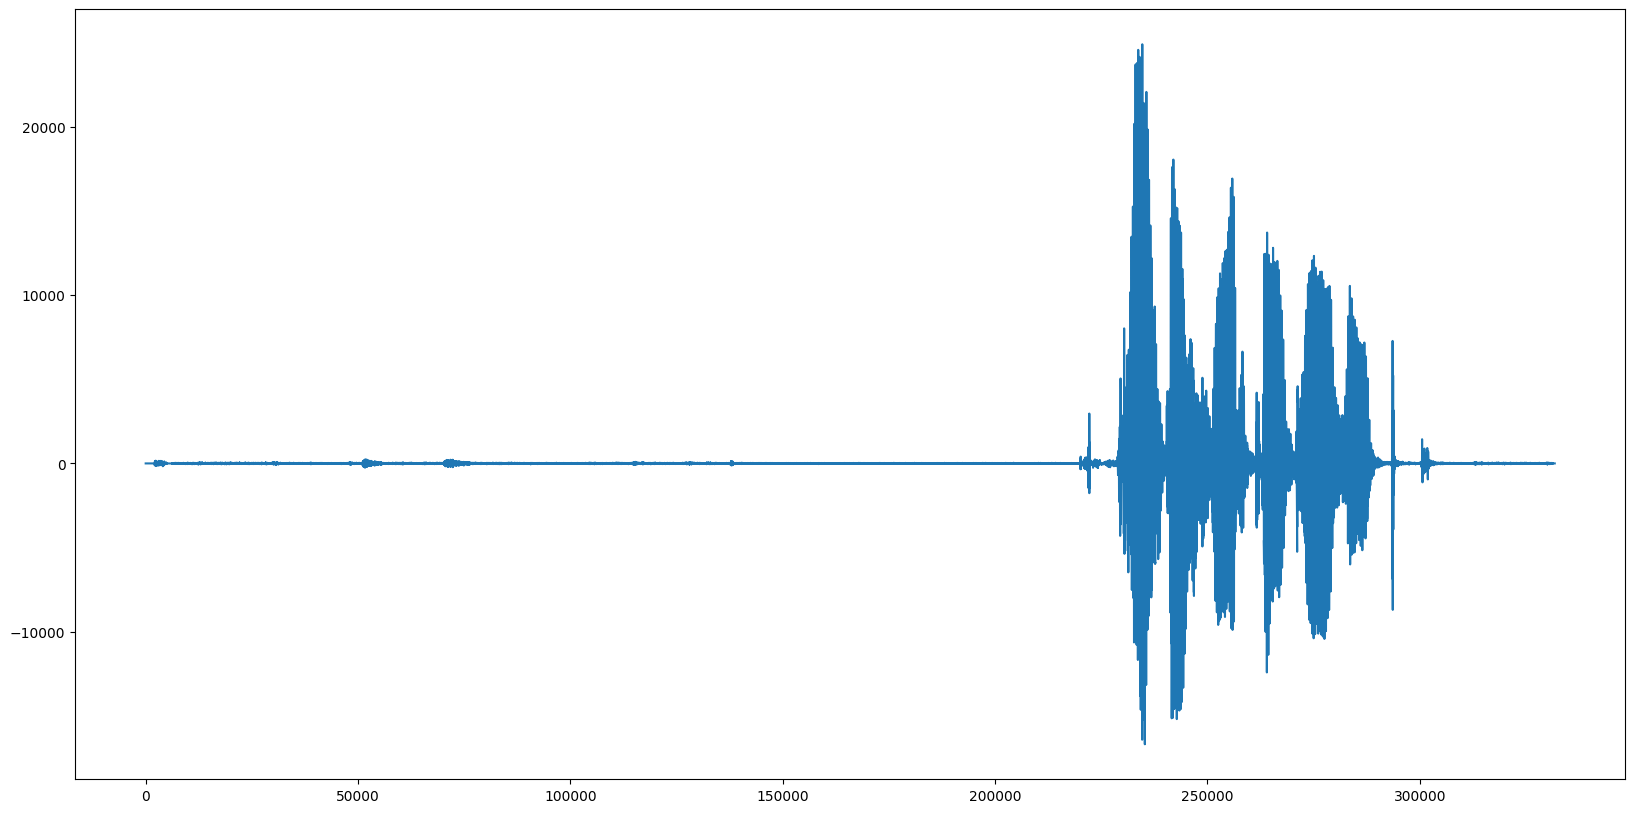

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

In [ ]:
import mimetypes
import io
import scipy.io.wavfile

# Save the audio data to a WAV file
file_path = "audio.wav"
scipy.io.wavfile.write(file_path, sr, audio)

# Now you can use guess_type with the file path
type = mimetypes.guess_type(file_path)
print(type)

('audio/x-wav', None)


In [ ]:
!pip install SpeechRecognition

In [ ]:
import speech_recognition as sr

# Transcribe the audio file
r = sr.Recognizer()
with sr.AudioFile(file_path) as source:
    audio_data = r.record(source)
    try:
        text = r.recognize_google(audio_data)
        print("Transcription:", text)
    except sr.UnknownValueError:
        print("Could not understand audio")
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")

Transcription: what is your company about


In [ ]:
transcription_output = text
with open("transcription.txt", "w") as f:
  f.write(transcription_output)

print("Transcription saved to transcription.txt")

Transcription saved to transcription.txt


In [ ]:
def answer_question_from_transcription(transcription_file):
    with open(transcription_file, "r") as f:
        question = f.read()

    # Find the most relevant context from your QA data (simplified approach)
    best_context = ""
    for pair in qa_pairs:
        if question.lower() in pair["question"].lower():
            best_context = pair["answer"]
            break

    if not best_context:
        return "I'm sorry, I don't have an answer to that question."

    inputs = tokenizer(question, best_context, return_tensors='pt')
    outputs = model(**inputs)
    answer_start_index = torch.argmax(outputs.start_logits)
    answer_end_index = torch.argmax(outputs.end_logits)
    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    answer = tokenizer.decode(predict_answer_tokens)

    return answer


# Example usage:
answer = answer_question_from_transcription("transcription.txt")
print(answer)

we provide high - quality products and services to meet your needs


In [ ]:
import gradio as gr

def answer_question_from_transcription_gradio(transcription_file):
  """
  Answers a question based on the transcribed text from an audio file.
  This function uses the existing BERT model and QA data to find the answer.
  """
  try:
    with open(transcription_file, "r") as f:
      question = f.read()

    best_context = ""
    for pair in qa_pairs:
      if question.lower() in pair["question"].lower():
        best_context = pair["answer"]
        break

    if not best_context:
      return "I'm sorry, I don't have an answer to that question."

    inputs = tokenizer(question, best_context, return_tensors='pt')
    outputs = model(**inputs)
    answer_start_index = torch.argmax(outputs.start_logits)
    answer_end_index = torch.argmax(outputs.end_logits)
    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    answer = tokenizer.decode(predict_answer_tokens)

    return answer
  except Exception as e:
    return f"Error processing your request: {e}"

iface = gr.Interface(
    fn=answer_question_from_transcription_gradio,
    inputs=gr.Textbox(lines=2, placeholder="Provide the path to the transcription file..."),
    outputs="text",
    title="BERT Q&A Chatbot (from Transcription)",
    description="Upload a transcription file containing your question and I will provide the answer."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bdc47fd273828c2bf6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
